 # Table of Contents
<div class="toc" style="margin-top: 1em;"><ul class="toc-item" id="toc-level0"><li><span><a href="http://localhost:8888/notebooks/Run%20Rabi.ipynb#Socket-Command-Example" data-toc-modified-id="Socket-Command-Example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Socket Command Example</a></span></li><li><span><a href="http://localhost:8888/notebooks/Run%20Rabi.ipynb#Set-Task-Coding" data-toc-modified-id="Set-Task-Coding-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set Task Coding</a></span><ul class="toc-item"><li><span><a href="http://localhost:8888/notebooks/Run%20Rabi.ipynb#Framework" data-toc-modified-id="Framework-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Framework</a></span></li><li><span><a href="http://localhost:8888/notebooks/Run%20Rabi.ipynb#Rabi-Flopping" data-toc-modified-id="Rabi-Flopping-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Rabi Flopping</a></span></li></ul></li></ul></div>

Code For Getting Data of KZ Experiment

# Socket Command Example

In [26]:
# from sympy import *
# init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display
from IPython.display import Math 
from math import *
import time
from IonControlerSocket import TaskSocket

# cmd_port = 'tcp://222.195.68.69:5556'
# # data port to get raw dataset
# data_port = 'tcp://222.195.68.69:5566'

# 本地运行
cmd_port = 'tcp://localhost:5556'
data_port = 'tcp://localhost:5566'

# cmd_port = 'tcp://222.195.68.7:5556'
# # data port to get raw dataset
# data_port = 'tcp://222.195.68.7:5566'

ion = TaskSocket(cmd_port=cmd_port, data_port=data_port)


# Set Task Coding

## Framework

In [27]:
strHeader='''
from Tasks.WaveTasks import SpectrumAWGTask
import numpy as np
'''

strSeq = '''
seq = [
(Cooling|Counting, 1000),
(Idle,             {}),
(Detecting,        {}),
]
'''.format(100,100.0)

strTask= '''
params={
    'Sequence': seq,
    'Setting' : {
        'Cycles per readout':100,
    },
}

Task = SpectrumAWGTask(params)  # set Task
'''


strPlots='''
# set plotters
from Tasks.Plotters import qtCountsPlotter as CountPlt
from Tasks.Plotters import qtLinesPlotter as LinePlt
from Tasks.Plotters import qtStatesPlotter as StatePlt

Plotters = [
[('counts', CountPlt([0,1]))],
[('states', StatePlt([0]))],
]
'''

strDataFolder='''
DataFolder = './AntiKZM/data/'
'''
code = strHeader + strSeq + strTask + strPlots

# %time ion.cmd('loadTask','Remote')
# %time ion.setCode(code)
# import time
# time.sleep(1)

## Rabi Flopping

In [34]:
omega_1 = 200e6 * 2 * pi

strSeqRabi = '''
ts  = np.linspace(0,300,101)

seq = [
(Cooling|Counting, 1000),
(Pumping,          50),
(Idle,             1),
(MW_Trigger,       0.02),
(MW,               ts),
(Detecting,        500),
(Idle,             1),
]
'''

strPlotsRabi='''
# set plotters
from Tasks.Plotters import qtCountsPlotter as CountPlt
from Tasks.Plotters import qtLinesPlotter as LinePlt
from Tasks.Plotters import qtStatesPlotter as StatePlt

Plotters = [
[('counts', CountPlt([0,1]))],
[('states', StatePlt([1],ts))],
]
'''

code = strHeader + strSeqRabi + strTask + strPlotsRabi + strDataFolder
# set code first, then load task
ion.setCode(code)

time.sleep(1)

dt = 1e-9
N = int(300e-6/dt)
ts0 = np.arange(N)*dt
wave = 0.1*np.sin(omega_1 * ts0)
wave1 = np.vstack((wave,wave))
amp1 = 1.0

print(ion.cmd('TaskFun', 'setWave',((wave1,wave1),(amp1,amp1))))
print(ion.cmd('start'))

x,y = ion.getPlotData('states',40000)  # get data


(True, None)
(True, 'Start Task: Remote')


6.66038087939e-05


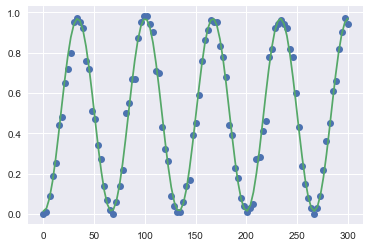

In [35]:
from scipy.optimize import curve_fit

# x,y = ion.getPlotData('states',40000)  # get data

# fitting
def funSin(x, x0, t0, A, B, tau):
    Y = A * np.exp(-(x - x0) / tau) * np.cos(2 * pi * (x - x0) / t0) / 2.0 + B
    return Y


def fitRabi(t, y):
    '''

    '''
    data_fft = abs(np.fft.fft(y))
    pos = max(enumerate(data_fft[1:len(t) / 2]), key=lambda x: x[1])[0]
    xmin = t[0]
    xmax = t[-1]
    xscale = xmax - xmin
    t0 = xscale / (pos + 1)
#     t0 = 40.0e-6
    A = max(y)
    B = 0.5
    x0 = 0.0
    tau = 0.5e-1  # 0.5 ms
    op = [x0, t0, A, B, tau]

    popt, pcov = curve_fit(funSin, t, y, op)
    # perr = np.sqrt(np.diag(pcov)
    #print (1.0 / popt[1], popt[1])

    return (1.0 / popt[1], popt, pcov)


data = y[:,1]
W0, popt, pcov = fitRabi(x*1e-6, data)   #fit
plt.plot(x,data, 'o')
plt.plot(x,funSin(x*1e-6,*popt))

print(popt[1])

In [ ]:
1/32.0